In [1]:
import numpy as np
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

from random_feature_gp import (generate_rff,
    bayesian_linear_model_loss, 
    bayesian_censored_model_loss, 
    fit_laplace_posterior, 
    laplace_predictive)

In [2]:
def branin_hoo(x):
    """
    Branin-Hoo test function (2d)
    http://www.sfu.ca/~ssurjano/branin.html
    """
    x1 = x[:,0]
    x2 = x[:,1]
    try:
        x1 = x1.numpy()
        x2 = x2.numpy()
    except:
        pass
    x1 = 15 * x1 - 5
    x2 = 15 * x2
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6
    s = 10
    t = 1/(8 * np.pi)
    v = (x2 - b*x1**2 + c*x1 - r)**2 + s * (1 - t) * np.cos(x1) + s
    if isinstance(x, torch.Tensor):
        return torch.FloatTensor(v)
    else:
        return v

In [3]:
THRESH = 10.0
    
def oracle(x, output_noise=0.0):
    r = branin_hoo(x)
#     r = r + torch.randn(r.shape)*output_noise
    r[r > THRESH] = THRESH
    return r

def oracle_binarized(x):
    r = oracle(x)
    fail = r >= THRESH
    r[fail] = 0
    r[~fail] = 1
    return r

def plot_test_function(fn):
    domain = torch.linspace(0, 1, 100)
    xx, yy = torch.meshgrid(domain, domain)
    xxyy = torch.stack((xx.ravel(), yy.ravel())).T
    zz = fn(xxyy).reshape(xx.shape)
    if zz.max() == 1.0:
        plt.contourf(xx, yy, zz)
    else:
        plt.contourf(xx, yy, zz, levels=20) # , levels=2**np.arange(0, int(np.ceil(np.log2(zz.max()))), 0.5)-1)

def plot_predictive_stddev(w_hat, H, lengthscale, noise, MAX_VALUE=torch.inf):
    domain = torch.linspace(0, 1, 100)
    xx, yy = torch.meshgrid(domain, domain)
    xxyy = torch.stack((xx.ravel(), yy.ravel())).T
    output = laplace_predictive(features(xxyy, lengthscale), w_hat, H)
    stddev = output.stddev + noise
    plt.contourf(xx, yy, stddev.reshape(xx.shape))   

/Users/brooks/miniforge3/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835428/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


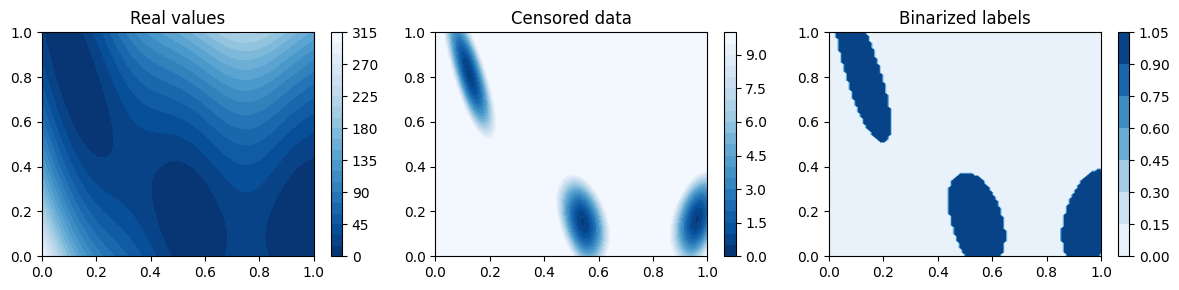

In [4]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plot_test_function(branin_hoo);
plt.title("Real values")
plt.set_cmap(cmap='Blues_r')
plt.colorbar()
plt.subplot(132)
plot_test_function(oracle);
plt.title("Censored data")
plt.colorbar()
plt.subplot(133)
plt.title("Binarized labels")
plot_test_function(oracle_binarized);
plt.set_cmap(cmap='Blues')
plt.colorbar();
plt.tight_layout();

tensor([10.0000, 10.0000, 10.0000,  7.2471, 10.0000, 10.0000, 10.0000,  5.7622,
        10.0000,  7.4537])

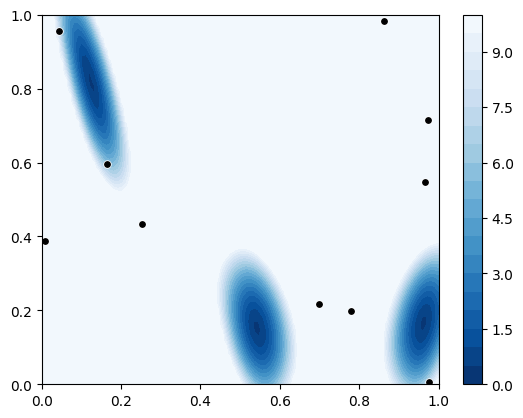

In [5]:
N_init = 10
np.random.seed(4)
x_init = torch.FloatTensor(np.random.rand(N_init, 2))
y_init = oracle(x_init)
features = generate_rff(2)
# print(y_init)

plot_test_function(oracle);
plt.set_cmap(cmap='Blues_r')
plt.colorbar();
plt.scatter(x_init[:,0], x_init[:,1], s=100, marker='.', color='w', )
plt.scatter(x_init[:,0], x_init[:,1], s=60, marker='.', color='k', )
y_init

In [6]:
def fit_linear_model(x, y, plot=False, debug=True):
    log_lengthscale = torch.tensor(1.0).requires_grad_(True)
    log_noise = torch.tensor(0.0).requires_grad_(True)

    phi = features(x, log_lengthscale.exp())
    w_hat = torch.zeros(phi.shape[-1]).requires_grad_(True)

    opt = torch.optim.Adagrad([w_hat, log_lengthscale, log_noise], lr=1.0)
    tmp = []
    for i in range(5000):
        opt.zero_grad();
        phi = features(x, log_lengthscale.exp())
        loss = bayesian_linear_model_loss(w_hat, phi, y, log_noise.exp())
        loss.backward()
        opt.step()
        tmp.append(loss.item())

    if plot:
        plt.plot(tmp[200:]);

    if debug:
        with torch.no_grad():
            print("lengthscale: %0.4f\nnoise: %0.4f" % (log_lengthscale.exp(), log_noise.exp()))
        print("LOSS:", loss.item())
    
    return w_hat, log_lengthscale.exp().item(), log_noise.exp().item()

lengthscale: 0.2547
noise: 0.6213
LOSS: 104.75496673583984


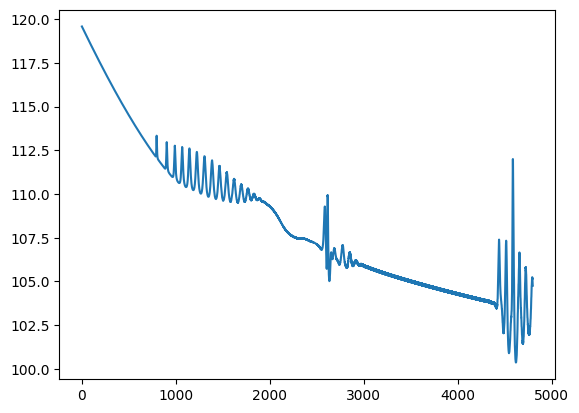

In [7]:
w_hat_linear, lengthscale_linear, noise_linear = fit_linear_model(x_init, y_init, plot=True)

In [8]:
H_linear = fit_laplace_posterior(w_hat_linear, 
                                 lambda w: bayesian_linear_model_loss(w, 
                                                                      features(x_init, lengthscale_linear),
                                                                      y_init, 
                                                                      noise_linear))

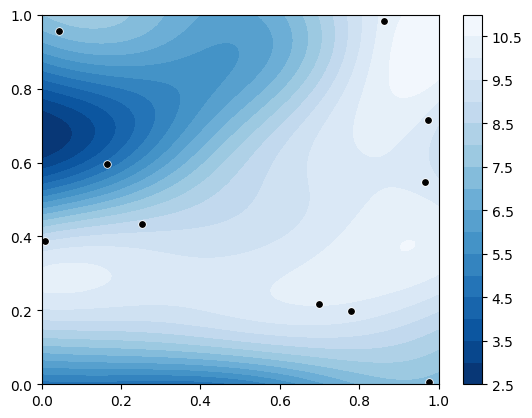

In [9]:
with torch.no_grad():
    plot_test_function(lambda x: features(x, lengthscale_linear) @ w_hat_linear)

plt.set_cmap(cmap='Blues_r')
plt.colorbar();
plt.scatter(x_init[:,0], x_init[:,1], s=100, marker='.', color='w', )
plt.scatter(x_init[:,0], x_init[:,1], s=60, marker='.', color='k', );


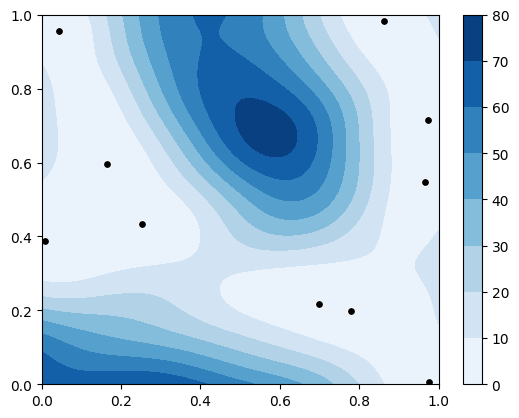

In [10]:

plot_predictive_stddev(w_hat_linear, H_linear, lengthscale_linear, noise_linear)
plt.set_cmap("Blues")
plt.colorbar();
plt.scatter(x_init[:,0], x_init[:,1], s=100, marker='.', color='w', )
plt.scatter(x_init[:,0], x_init[:,1], s=60, marker='.', color='k', );

In [11]:
def expected_improvement_mc(x, y_min, w_hat, H, lengthscale, noise, MAX_VALUE=torch.inf):
    output = laplace_predictive(features(x, lengthscale), w_hat, H)
    output_noisy = dist.Normal(output.loc, output.scale + noise)
    N_samples = 100
    spacing = torch.linspace(0, 1, N_samples+1)[:-1]
    z = output_noisy.icdf((spacing + torch.rand_like(spacing)*spacing[1])[:,None])
    z.clamp_max_(MAX_VALUE)
    EI = torch.maximum(y_min - z, torch.zeros_like(z)).mean(0) # ((z < y_min).float() * (y_min - z)).mean(0)
    return EI

def plot_expected_improvement(y_min, w_hat, H, lengthscale, noise, MAX_VALUE=torch.inf):
    domain = torch.linspace(0, 1, 100)
    xx, yy = torch.meshgrid(domain, domain)
    xxyy = torch.stack((xx.ravel(), yy.ravel())).T
    EI = expected_improvement_mc(xxyy, y_min, w_hat, H, lengthscale, noise, MAX_VALUE)
    plt.contourf(xx, yy, EI.reshape(xx.shape))
    plt.colorbar();


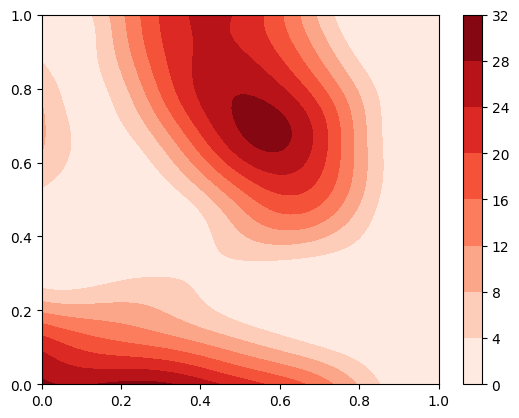

In [12]:
plt.set_cmap("Reds")
plot_expected_improvement(y_init.min(), w_hat_linear, H_linear, lengthscale_linear, noise_linear)

In [13]:
def fit_censored_model(x, y, plot=False, debug=True):
    log_lengthscale = torch.tensor(1.0).requires_grad_(True)
    log_noise = torch.tensor(0.0).requires_grad_(True)

    phi = features(x, log_lengthscale.exp())
    w_hat = torch.zeros(phi.shape[-1]).requires_grad_(True)

    opt = torch.optim.Adagrad([w_hat, log_lengthscale, log_noise], lr=0.1)
    tmp = []
    for i in range(5000):
        opt.zero_grad();
        phi = features(x, log_lengthscale.exp())
        loss = bayesian_censored_model_loss(w_hat, phi, y, log_noise.exp(), MAX_VALUE=THRESH)
        loss.backward()
        opt.step()
        tmp.append(loss.item())
#         print(loss.item())

    if plot:
        plt.plot(tmp[200:]);

    if debug:
        with torch.no_grad():
            print("lengthscale: %0.4f\nnoise: %0.4f" % (log_lengthscale.exp(), log_noise.exp()))
        print("LOSS:", loss.item())
    
    return w_hat, log_lengthscale.exp().detach(), log_noise.exp().detach()

lengthscale: 0.3628
noise: 0.1070
LOSS: 91.338623046875


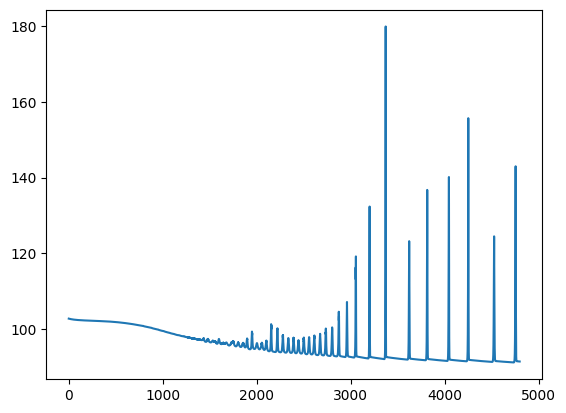

In [14]:
w_hat_tobit, lengthscale_tobit, noise_tobit = fit_censored_model(x_init, y_init, plot=True)

In [15]:
H_tobit = fit_laplace_posterior(w_hat_tobit, 
                                lambda w: bayesian_censored_model_loss(w, 
                                                                       features(x_init, lengthscale_tobit), 
                                                                       y_init, 
                                                                       noise_tobit,
                                                                       MAX_VALUE=THRESH))

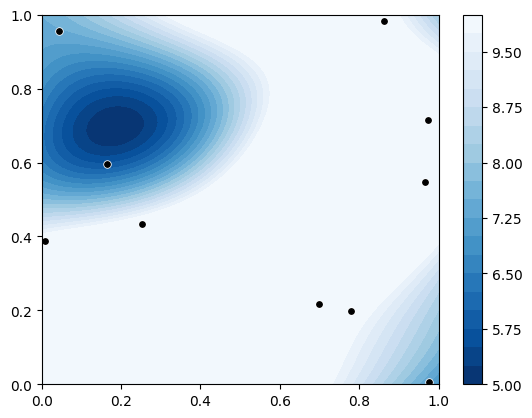

In [16]:
with torch.no_grad():
    plot_test_function(lambda x: torch.clamp_max(features(x, lengthscale_tobit) @ w_hat_tobit, THRESH))

plt.set_cmap(cmap='Blues_r')    
plt.colorbar();
plt.scatter(x_init[:,0], x_init[:,1], s=100, marker='.', color='w', )
plt.scatter(x_init[:,0], x_init[:,1], s=60, marker='.', color='k', );

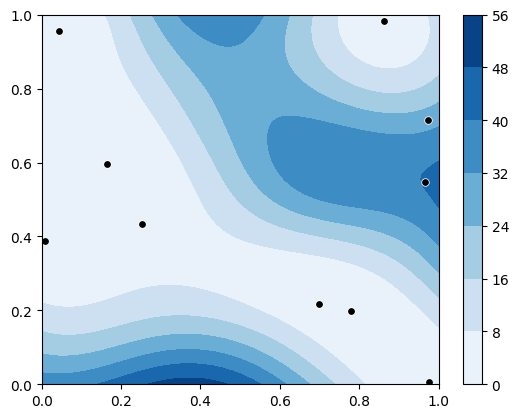

In [17]:
plot_predictive_stddev(w_hat_tobit, H_tobit, lengthscale_tobit, noise_tobit)
plt.set_cmap("Blues")
plt.colorbar();
plt.scatter(x_init[:,0], x_init[:,1], s=100, marker='.', color='w', )
plt.scatter(x_init[:,0], x_init[:,1], s=60, marker='.', color='k', );

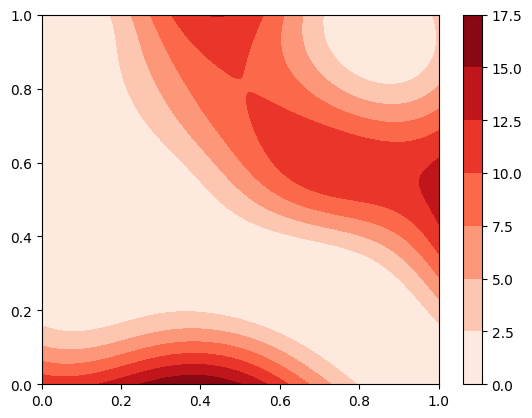

In [18]:
plt.set_cmap("Reds")
plot_expected_improvement(y_init.min(), w_hat_tobit, H_tobit, lengthscale_tobit, noise_tobit, MAX_VALUE=THRESH)

# Actually test BO. Linear model first

In [19]:
X_linear = x_init.clone()
y_linear = y_init.clone()

In [20]:
def plot_BO_step(X, y, w_hat, H, lengthscale, noise, MAX_VALUE=torch.inf):
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    with torch.no_grad():
        plot_test_function(lambda x: torch.clamp_max(features(x, lengthscale) @ w_hat, MAX_VALUE))

    plt.set_cmap(cmap='Blues_r')
    plt.colorbar();
    plt.scatter(X[:N_init,0], X[:N_init,1], s=100, marker='.', color='w', )
    plt.scatter(X[:N_init,0], X[:N_init,1], s=60, marker='.', color='k', )
    plt.scatter(X[N_init:,0], X[N_init:,1], s=100, marker='.', color='w', )
    plt.scatter(X[N_init:,0], X[N_init:,1], s=60, marker='.', color='r', )
    plt.subplot(122)
    plt.set_cmap("Reds")
    plot_expected_improvement(y.min(), w_hat, H, lengthscale, noise, MAX_VALUE=MAX_VALUE)
    plt.scatter(X[:N_init,0], X[:N_init,1], s=100, marker='.', color='w', )
    plt.scatter(X[:N_init,0], X[:N_init,1], s=60, marker='.', color='k', )
    plt.scatter(X[N_init:,0], X[N_init:,1], s=100, marker='.', color='w', )
    plt.scatter(X[N_init:,0], X[N_init:,1], s=60, marker='.', color='r', )


def bo_iteration_linear(X_linear, y_linear):
    w_hat, lengthscale, noise = fit_linear_model(X_linear, y_linear, debug=False)
    H = fit_laplace_posterior(w_hat, 
                              lambda w: bayesian_linear_model_loss(w,
                                                                   features(X_linear, lengthscale),
                                                                   y_linear, 
                                                                   noise))
    # gridsearch acquisition function
    domain = torch.linspace(0, 1, 200)
    xx, yy = torch.meshgrid(domain, domain)
    xxyy = torch.stack((xx.ravel(), yy.ravel())).T
    EI = expected_improvement_mc(xxyy, y_linear.min(), w_hat, H, lengthscale, noise)
    EI = EI.reshape(xx.shape)
    m0 = EI.argmax(0)
    m1 = EI[m0,torch.arange(len(domain))].argmax(0)
    X_next = torch.stack((domain[m0[m1]], domain[m1]))
    y_next = oracle(X_next[None,:])
    X_linear = torch.concat((X_linear, X_next[None,:]))
    y_linear = torch.concat((y_linear, y_next))
    print("Eval at",X_next,"->", y_next)
    print("Best value %0.2f from %d evaluations" % (y_linear.min().item(),len(y_linear)))
    
    plot_BO_step(X_linear, y_linear, w_hat, H, lengthscale, noise)
    plt.show();
    
    return X_linear, y_linear

Eval at tensor([0.5628, 0.6935]) -> tensor([10.])
Best value 5.76 from 11 evaluations


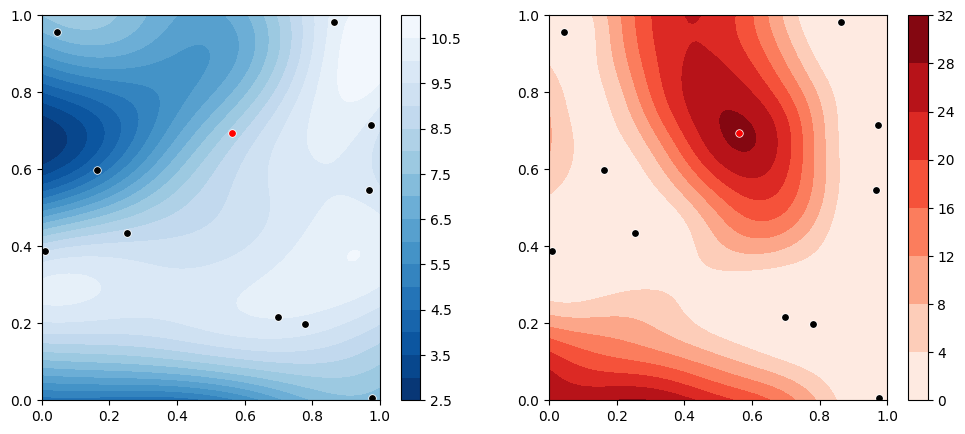

Eval at tensor([0.2462, 0.0000]) -> tensor([10.])
Best value 5.76 from 12 evaluations


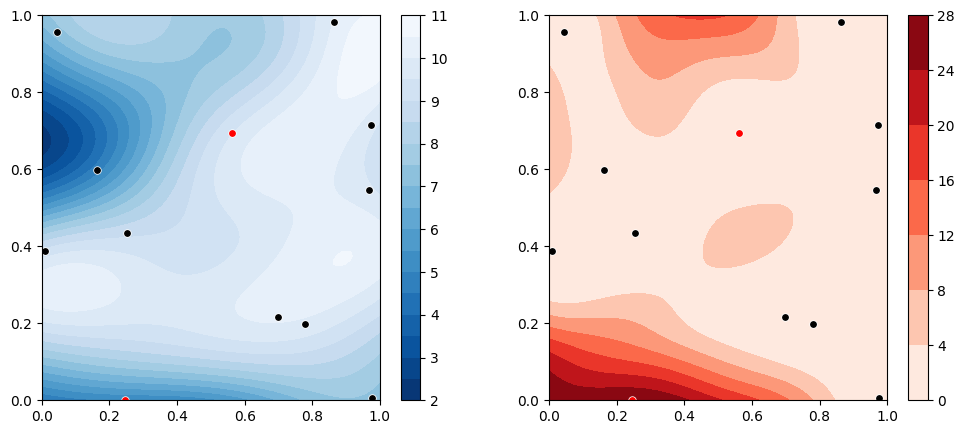

Eval at tensor([0., 0.]) -> tensor([10.])
Best value 5.76 from 13 evaluations


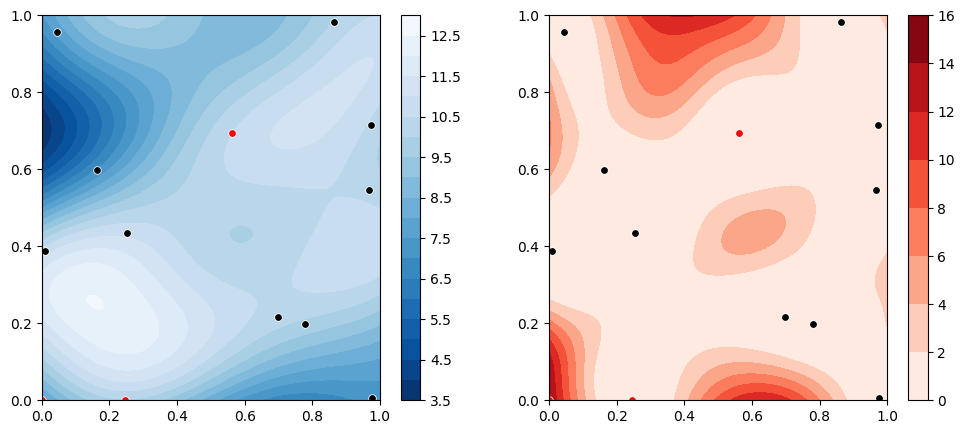

Eval at tensor([0.4372, 1.0000]) -> tensor([10.])
Best value 5.76 from 14 evaluations


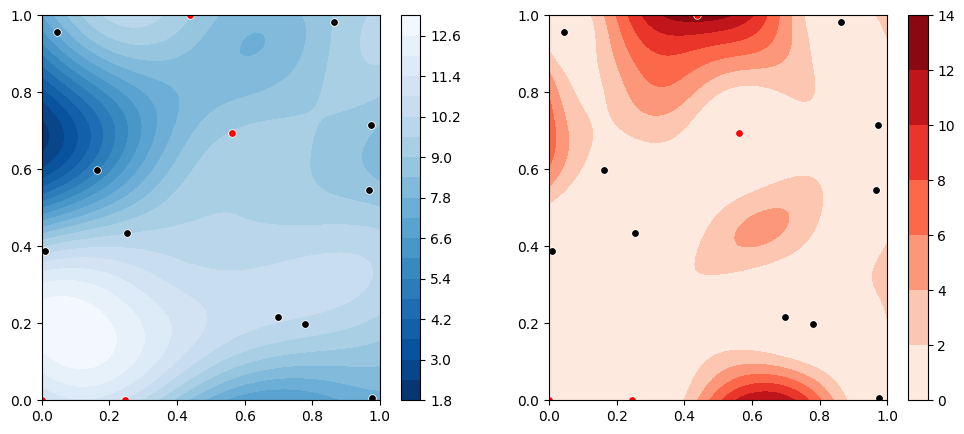

Eval at tensor([0.6332, 0.0000]) -> tensor([10.])
Best value 5.76 from 15 evaluations


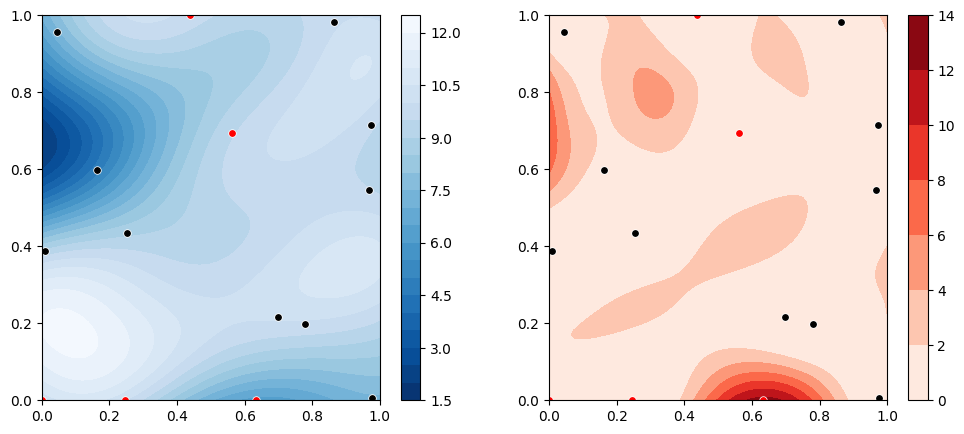

Eval at tensor([0.0000, 0.6834]) -> tensor([10.])
Best value 5.76 from 16 evaluations


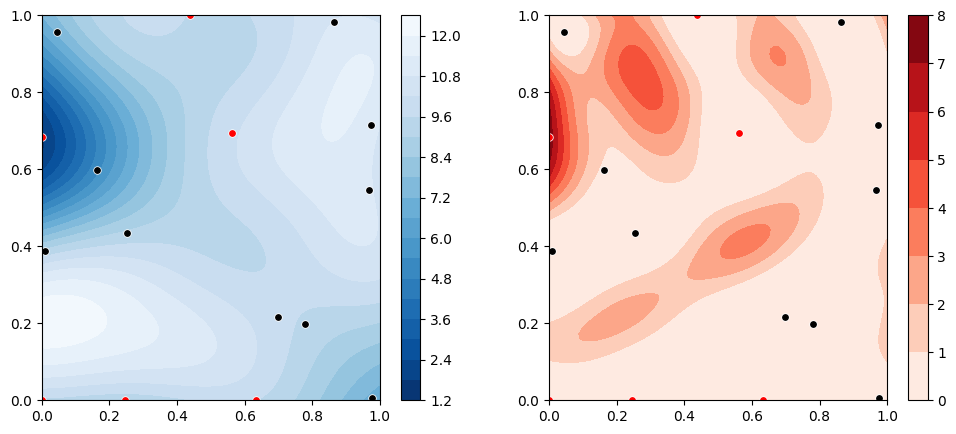

Eval at tensor([1., 1.]) -> tensor([10.])
Best value 5.76 from 17 evaluations


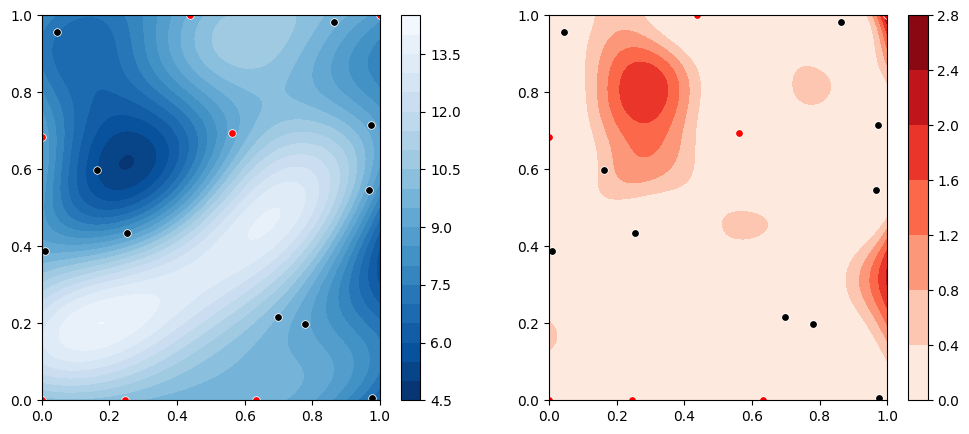

Eval at tensor([1.0000, 0.3166]) -> tensor([4.9909])
Best value 4.99 from 18 evaluations


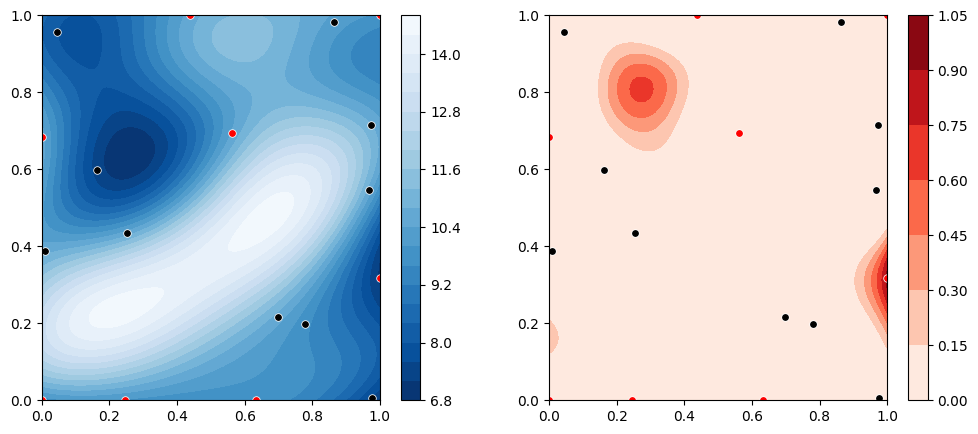

Eval at tensor([1.0000, 0.3367]) -> tensor([6.1346])
Best value 4.99 from 19 evaluations


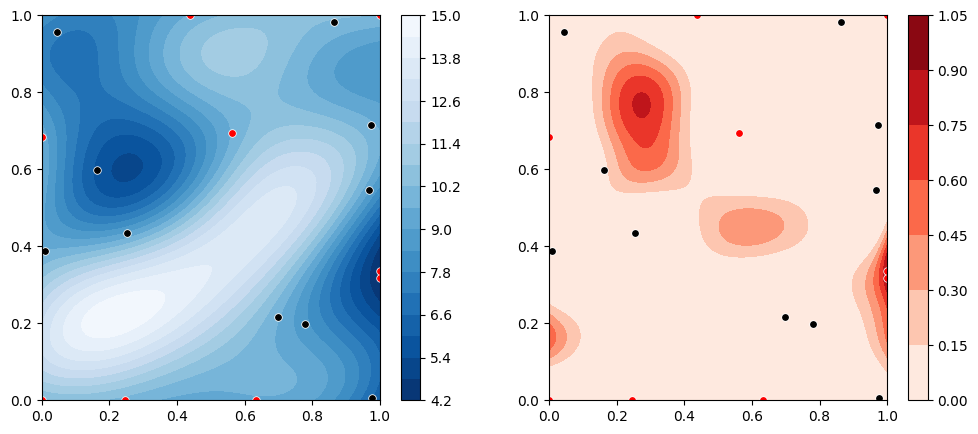

Eval at tensor([0.2714, 0.7638]) -> tensor([10.])
Best value 4.99 from 20 evaluations


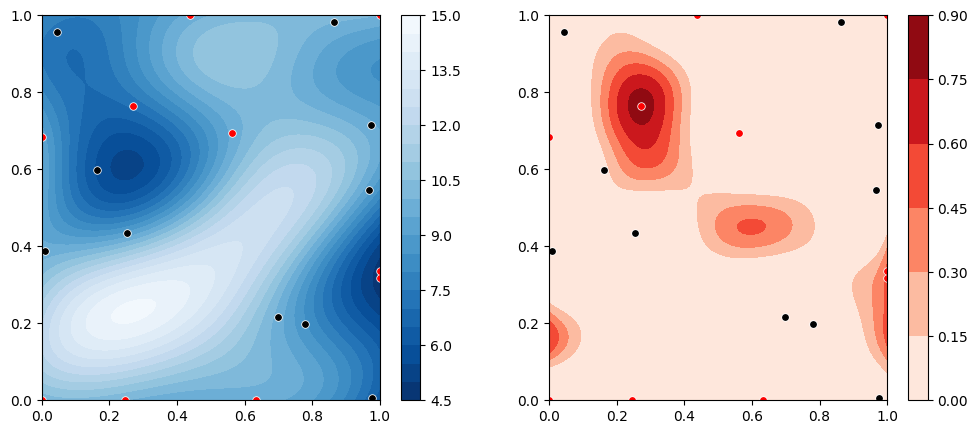

Eval at tensor([0.6382, 0.4673]) -> tensor([10.])
Best value 4.99 from 21 evaluations


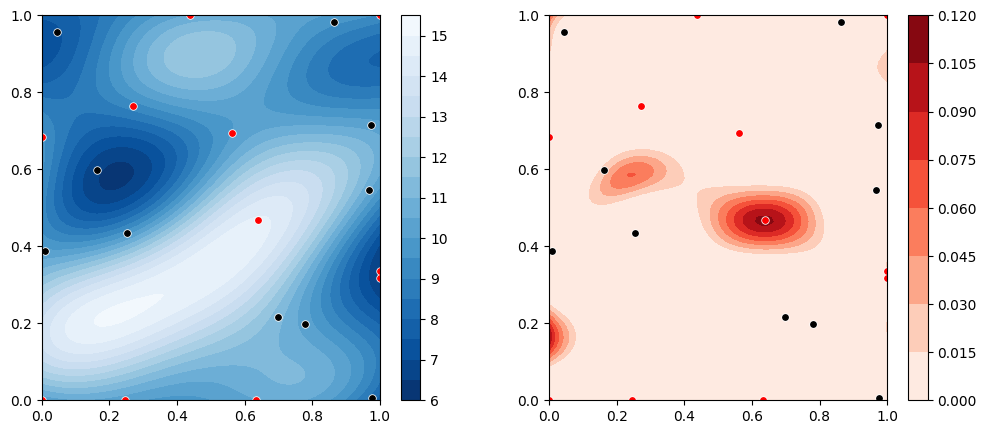

Eval at tensor([1.0000, 0.2462]) -> tensor([2.4199])
Best value 2.42 from 22 evaluations


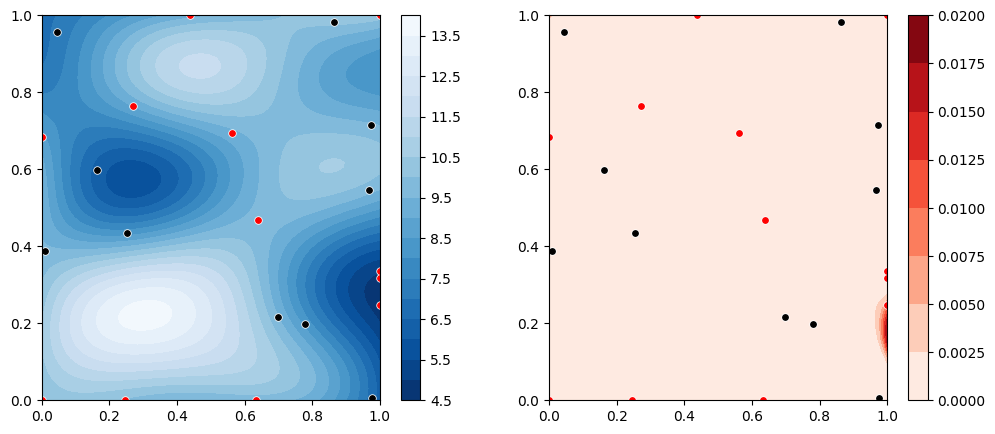

Eval at tensor([1.0000, 0.1608]) -> tensor([2.2923])
Best value 2.29 from 23 evaluations


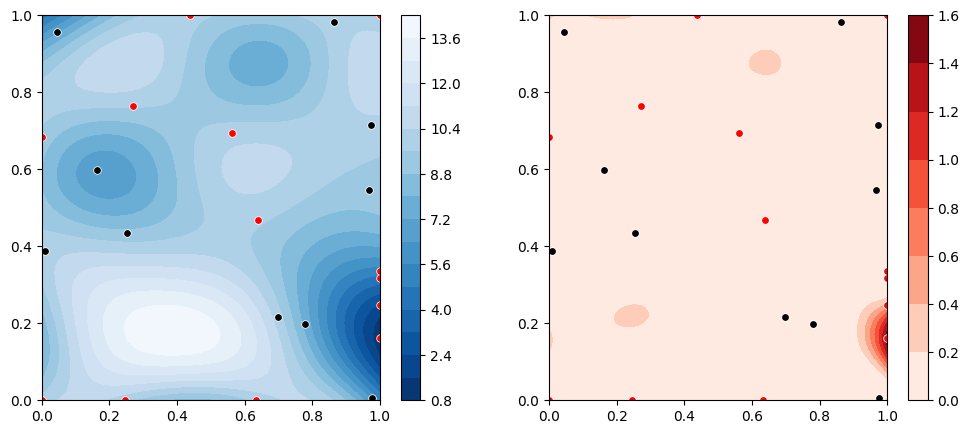

Eval at tensor([1.0000, 0.1658]) -> tensor([2.2089])
Best value 2.21 from 24 evaluations


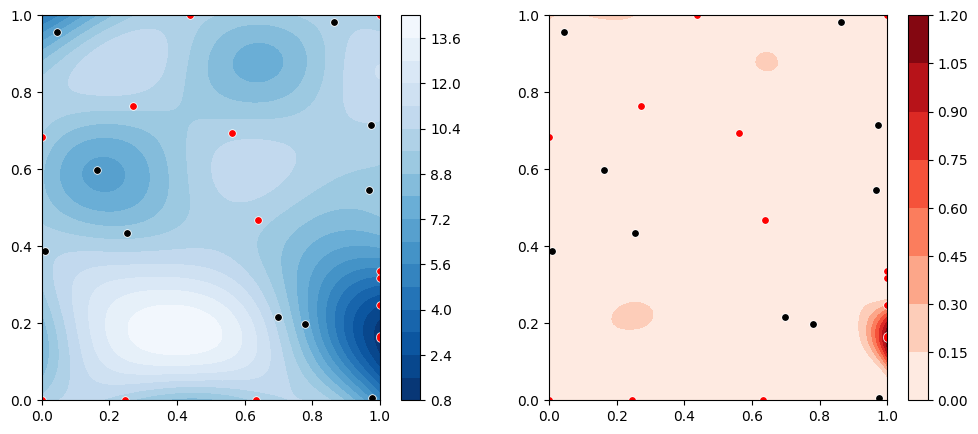

Eval at tensor([1.0000, 0.1658]) -> tensor([2.2089])
Best value 2.21 from 25 evaluations


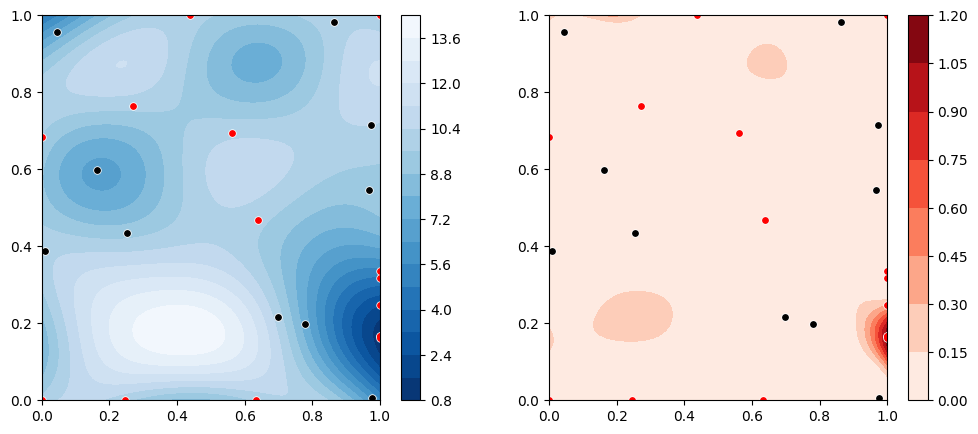

Eval at tensor([0.6482, 0.8894]) -> tensor([10.])
Best value 2.21 from 26 evaluations


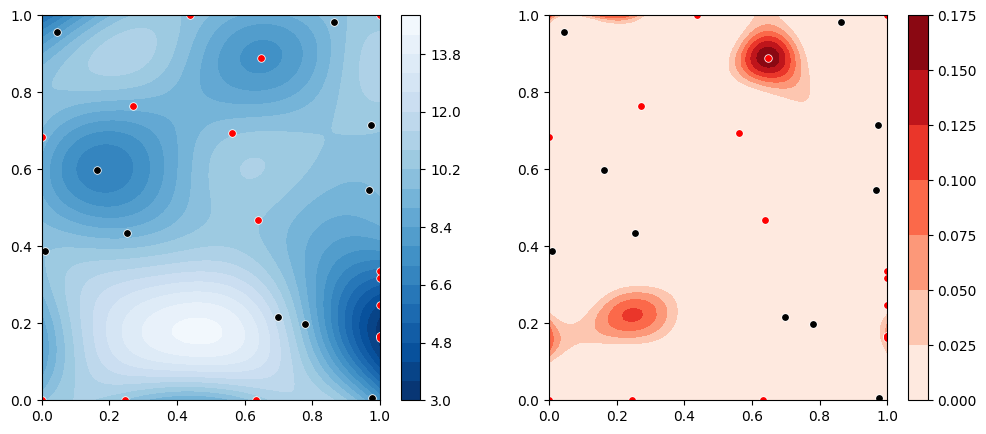

Eval at tensor([0.1859, 1.0000]) -> tensor([10.])
Best value 2.21 from 27 evaluations


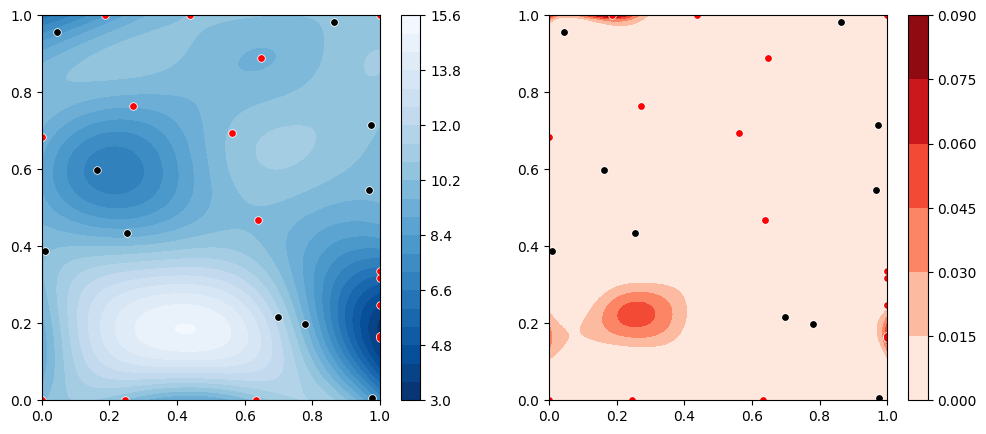

Eval at tensor([1.0000, 0.1608]) -> tensor([2.2923])
Best value 2.21 from 28 evaluations


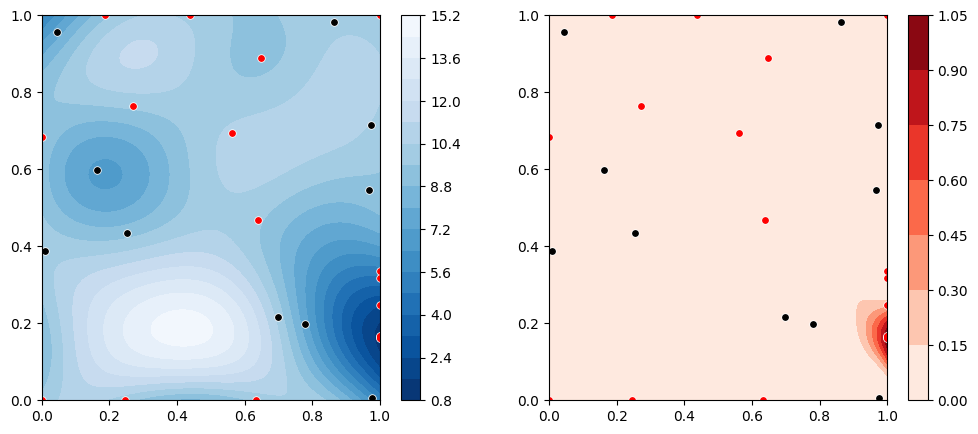

Eval at tensor([1.0000, 0.1608]) -> tensor([2.2923])
Best value 2.21 from 29 evaluations


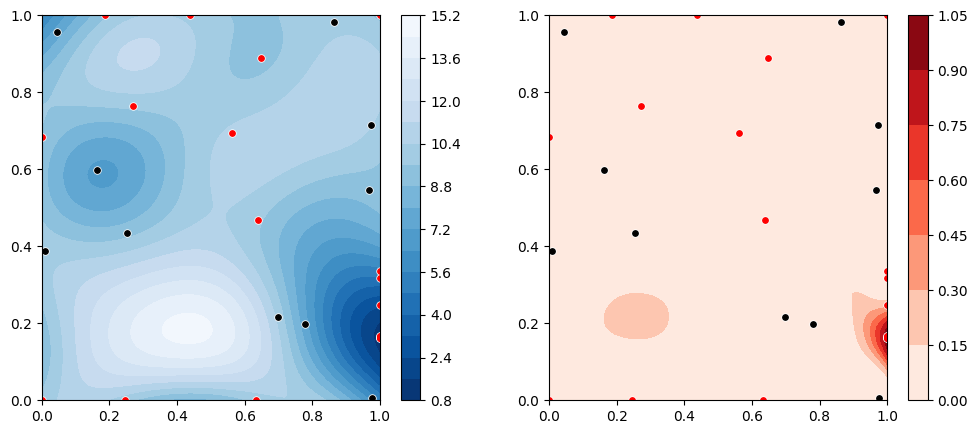

Eval at tensor([0.2563, 0.2211]) -> tensor([10.])
Best value 2.21 from 30 evaluations


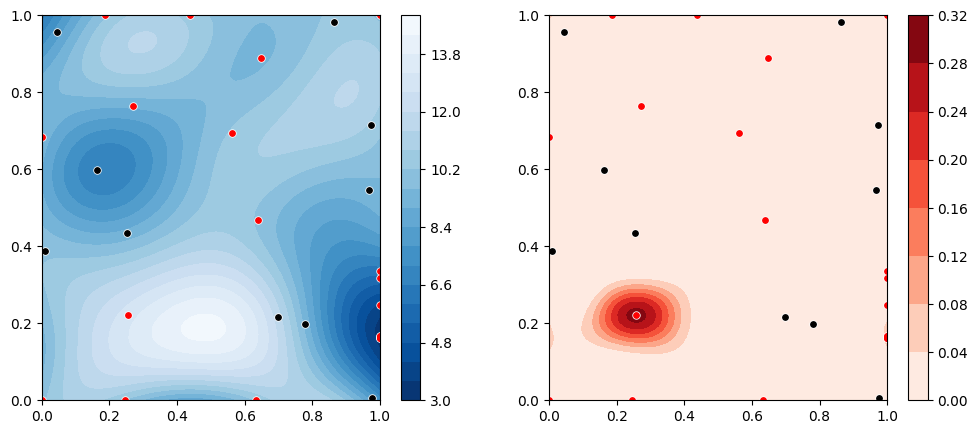

In [21]:
for i in range(20):
    X_linear, y_linear = bo_iteration_linear(X_linear, y_linear)

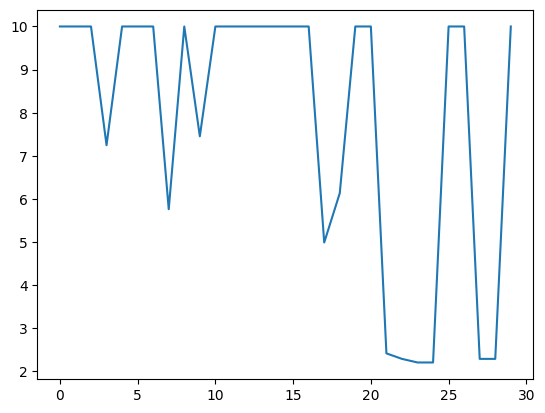

In [29]:
plt.plot(y_linear);

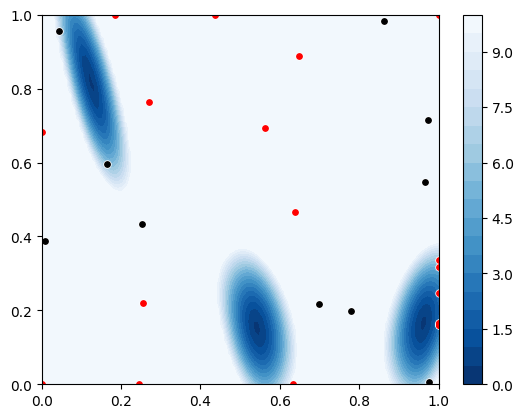

In [23]:
with torch.no_grad():
    plot_test_function(oracle)

plt.set_cmap(cmap='Blues_r')
plt.colorbar();
plt.scatter(X_linear[:N_init,0], X_linear[:N_init,1], s=100, marker='.', color='w', )
plt.scatter(X_linear[:N_init,0], X_linear[:N_init,1], s=60, marker='.', color='k', )
plt.scatter(X_linear[N_init:,0], X_linear[N_init:,1], s=100, marker='.', color='w', )
plt.scatter(X_linear[N_init:,0], X_linear[N_init:,1], s=60, marker='.', color='r', )

# Now BO with tobit model.

In [24]:
X_tobit = x_init.clone()
y_tobit = y_init.clone()

In [25]:
def bo_iteration_tobit(X_tobit, y_tobit):
    w_hat, lengthscale, noise = fit_censored_model(X_tobit, y_tobit, debug=False)
    H = fit_laplace_posterior(w_hat, 
                              lambda w: bayesian_censored_model_loss(w,
                                                                     features(X_tobit, lengthscale),
                                                                     y_tobit, 
                                                                     noise,
                                                                     MAX_VALUE=THRESH))
    # gridsearch acquisition function
    domain = torch.linspace(0, 1, 200)
    xx, yy = torch.meshgrid(domain, domain)
    xxyy = torch.stack((xx.ravel(), yy.ravel())).T
    EI = expected_improvement_mc(xxyy, y_tobit.min(), w_hat, H, lengthscale, noise, MAX_VALUE=THRESH)
    EI = EI.reshape(xx.shape)
    m0 = EI.argmax(0)
    m1 = EI[m0,torch.arange(len(domain))].argmax(0)
    X_next = torch.stack((domain[m0[m1]], domain[m1]))
    y_next = oracle(X_next[None,:])
    X_tobit = torch.concat((X_tobit, X_next[None,:]))
    y_tobit = torch.concat((y_tobit, y_next))
    print("Eval at",X_next,"->", y_next)
    print("Best value %0.2f from %d evaluations" % (y_tobit.min().item(),len(y_tobit)))
    
    plot_BO_step(X_tobit, y_tobit, w_hat, H, lengthscale, noise, MAX_VALUE=THRESH)
    plt.show();
    
    return X_tobit, y_tobit

Eval at tensor([0.3819, 0.0000]) -> tensor([10.])
Best value 5.76 from 11 evaluations


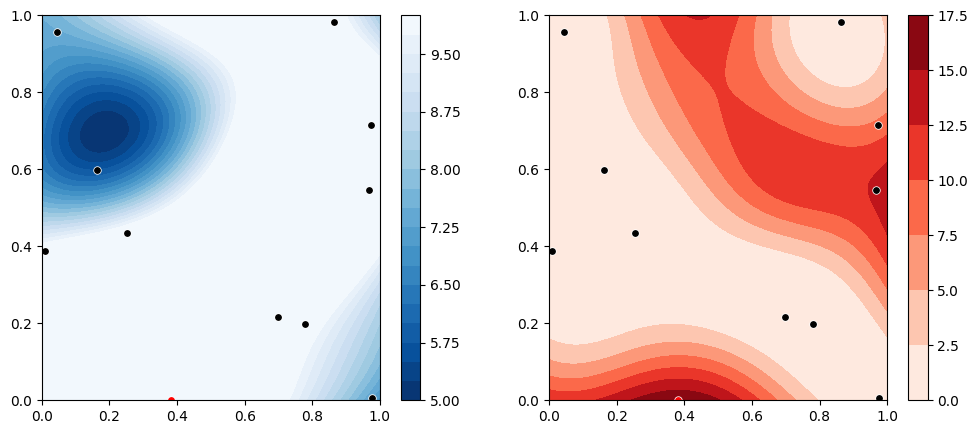

Eval at tensor([0.3769, 0.0000]) -> tensor([10.])
Best value 5.76 from 12 evaluations


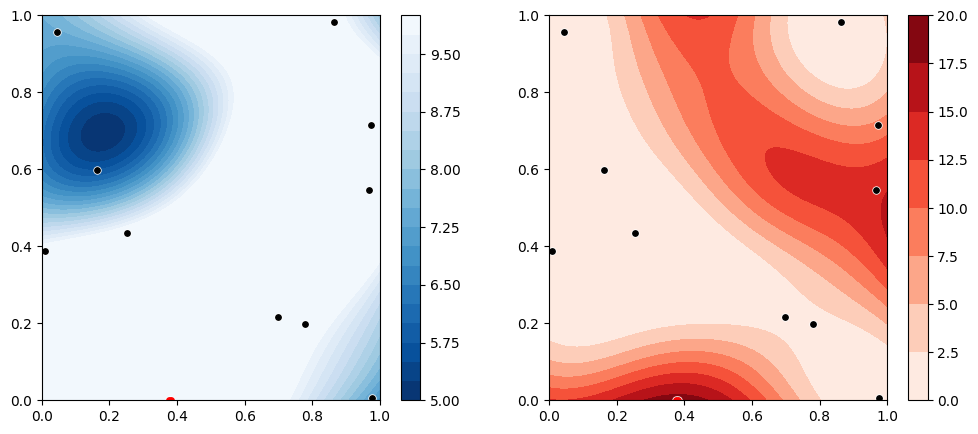

Eval at tensor([1.0000, 0.9749]) -> tensor([10.])
Best value 5.76 from 13 evaluations


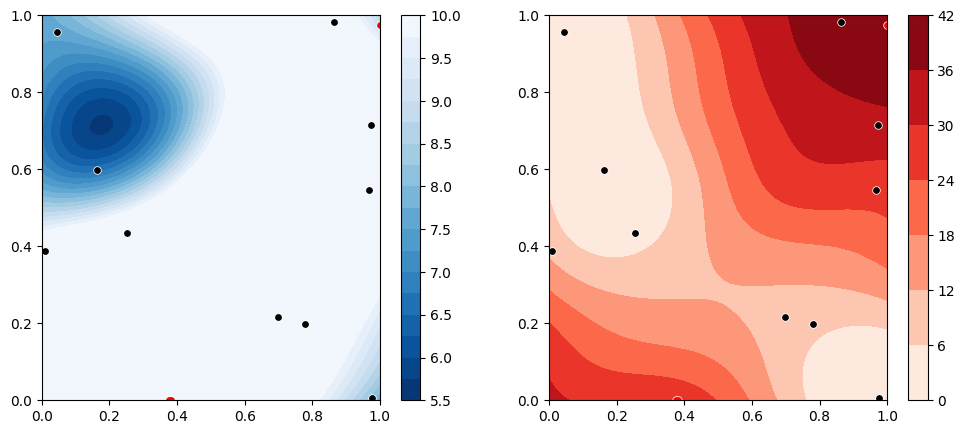

Eval at tensor([0.5025, 1.0000]) -> tensor([10.])
Best value 5.76 from 14 evaluations


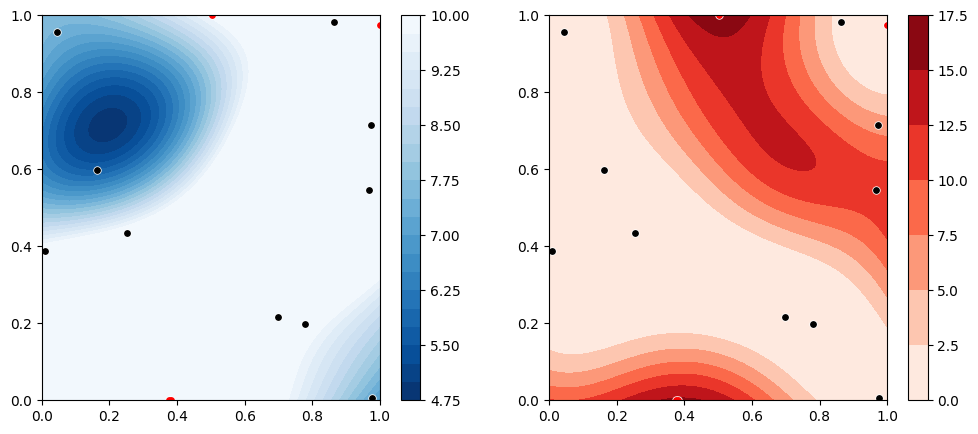

Eval at tensor([0.5075, 1.0000]) -> tensor([10.])
Best value 5.76 from 15 evaluations


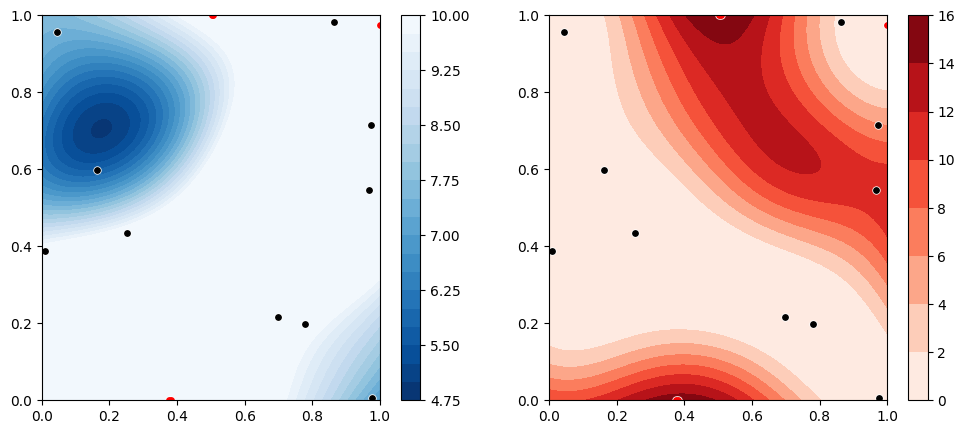

Eval at tensor([1., 1.]) -> tensor([10.])
Best value 5.76 from 16 evaluations


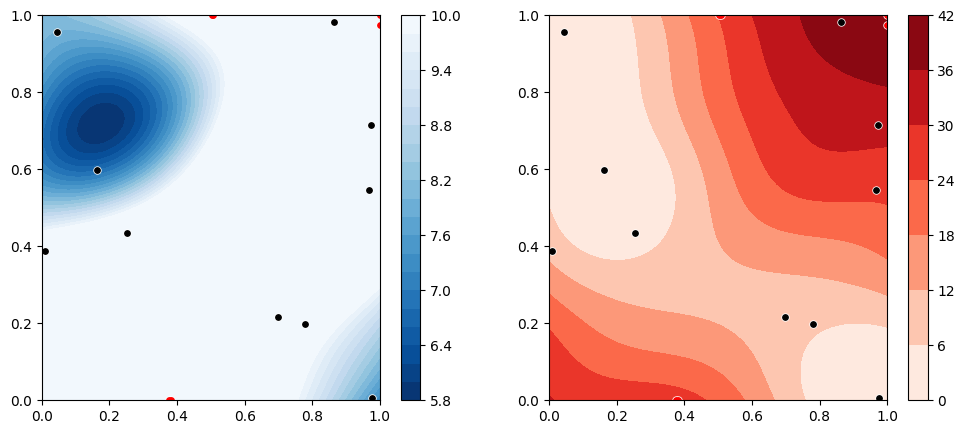

Eval at tensor([0.5075, 1.0000]) -> tensor([10.])
Best value 5.76 from 17 evaluations


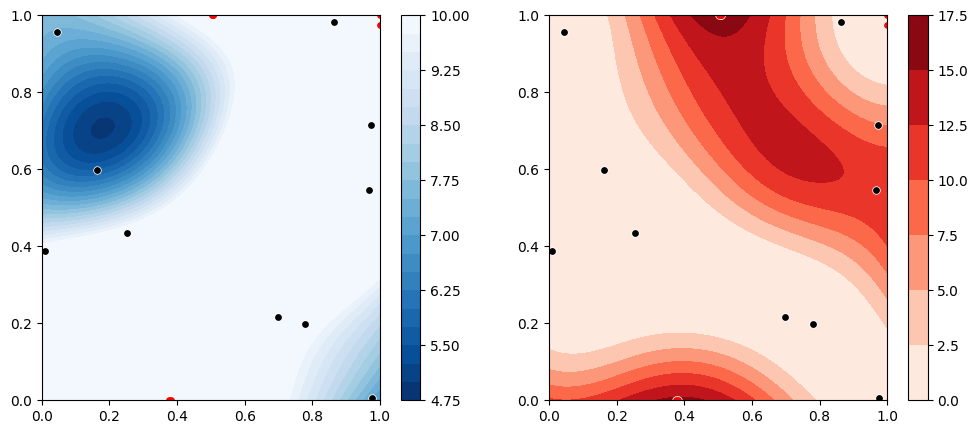

Eval at tensor([0.5075, 1.0000]) -> tensor([10.])
Best value 5.76 from 18 evaluations


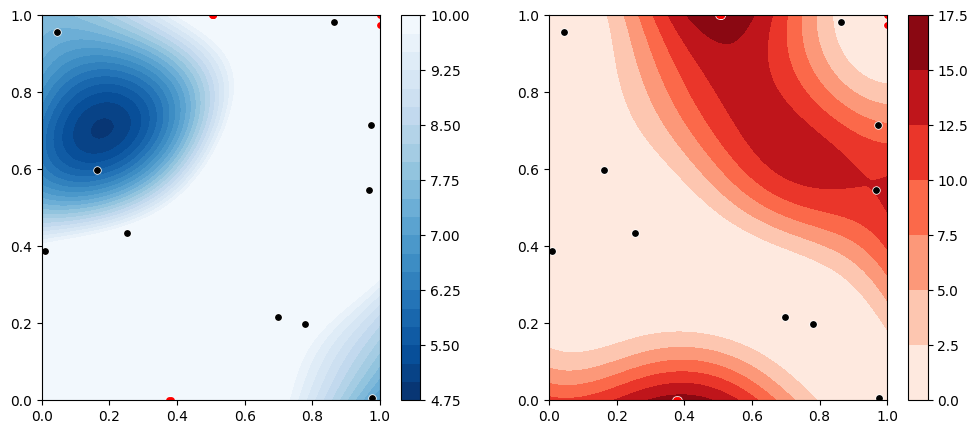

Eval at tensor([0.5075, 1.0000]) -> tensor([10.])
Best value 5.76 from 19 evaluations


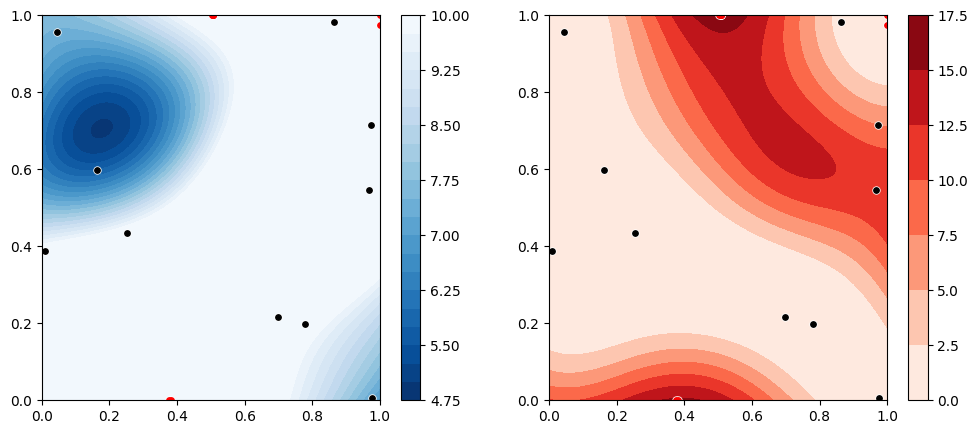

Eval at tensor([0.3869, 0.0000]) -> tensor([10.])
Best value 5.76 from 20 evaluations


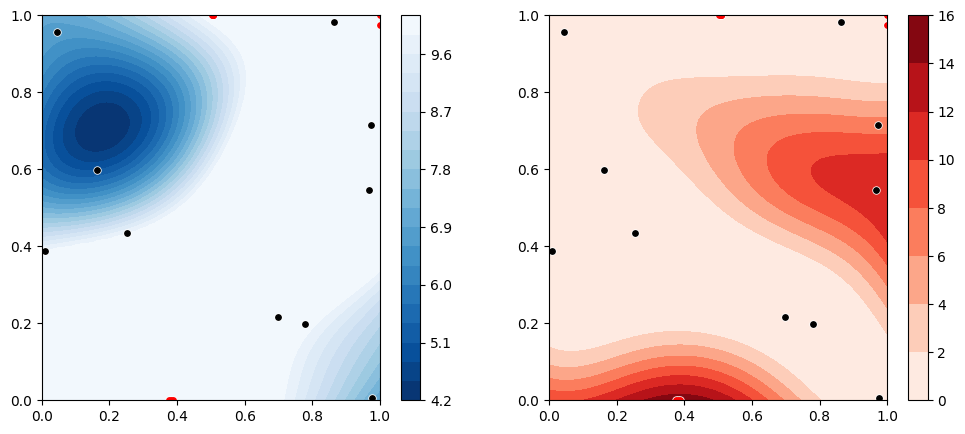

Eval at tensor([0.5075, 1.0000]) -> tensor([10.])
Best value 5.76 from 21 evaluations


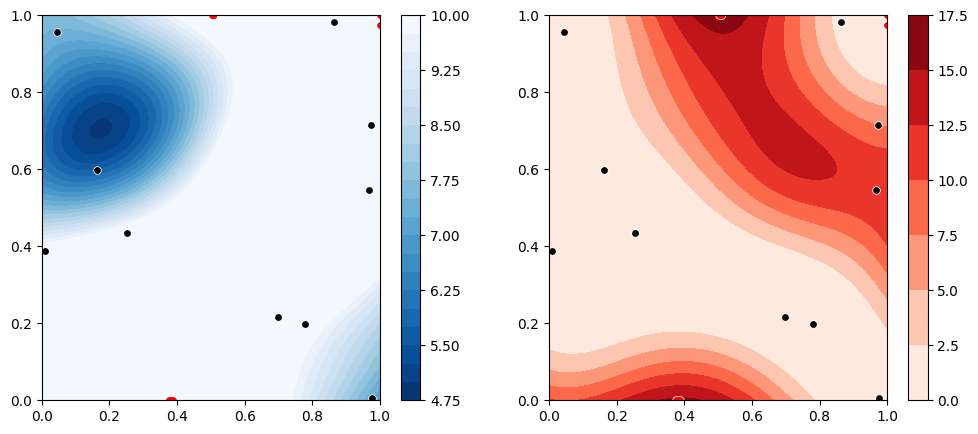

Eval at tensor([0.5075, 1.0000]) -> tensor([10.])
Best value 5.76 from 22 evaluations


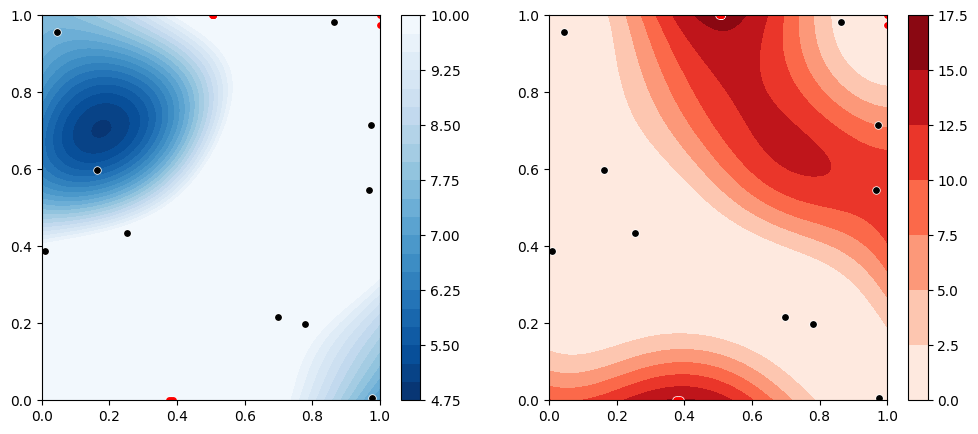

Eval at tensor([0.5075, 1.0000]) -> tensor([10.])
Best value 5.76 from 23 evaluations


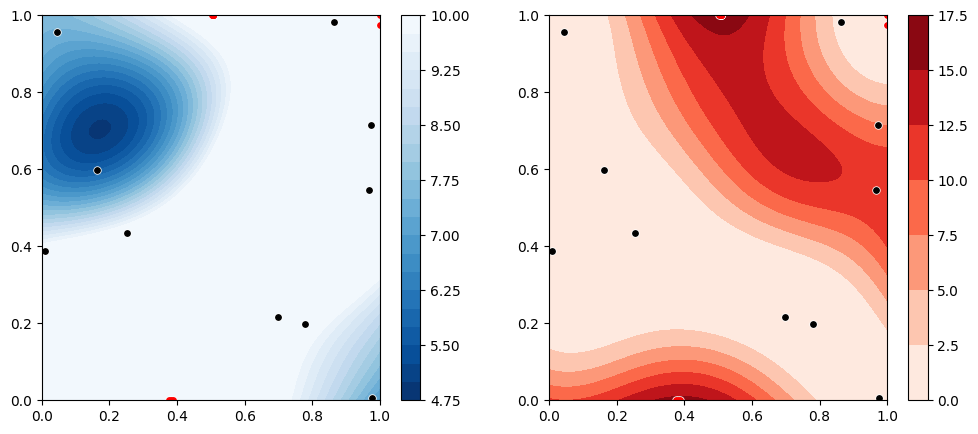

Eval at tensor([0.3970, 0.0000]) -> tensor([10.])
Best value 5.76 from 24 evaluations


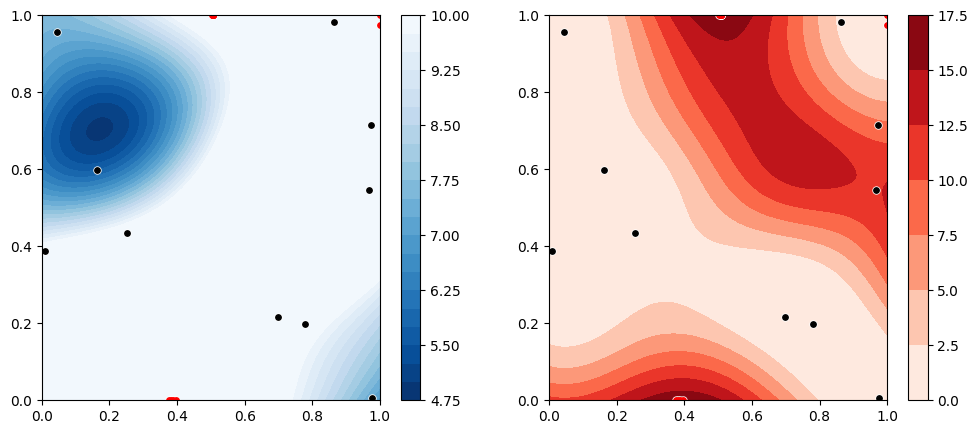

Eval at tensor([0.5075, 1.0000]) -> tensor([10.])
Best value 5.76 from 25 evaluations


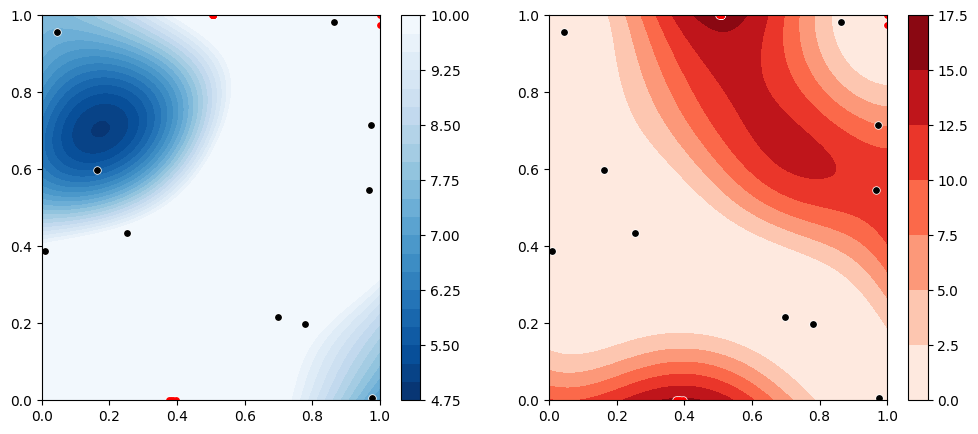

Eval at tensor([0.5075, 1.0000]) -> tensor([10.])
Best value 5.76 from 26 evaluations


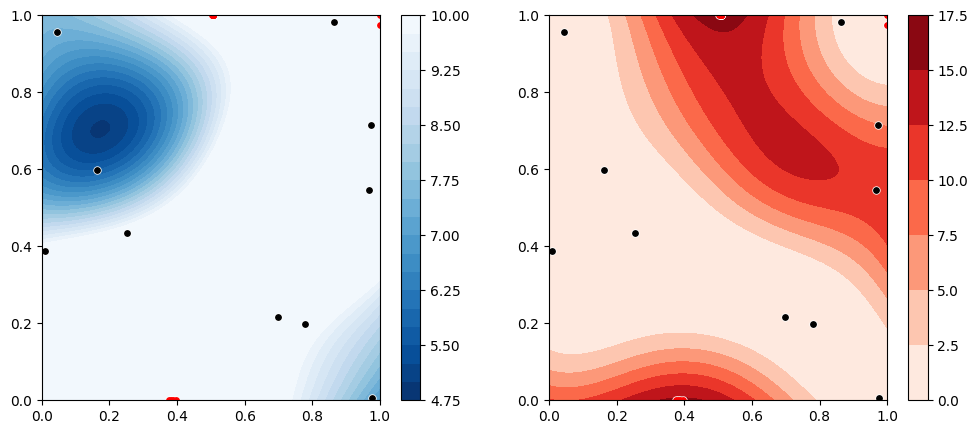

Eval at tensor([0.3920, 0.0000]) -> tensor([10.])
Best value 5.76 from 27 evaluations


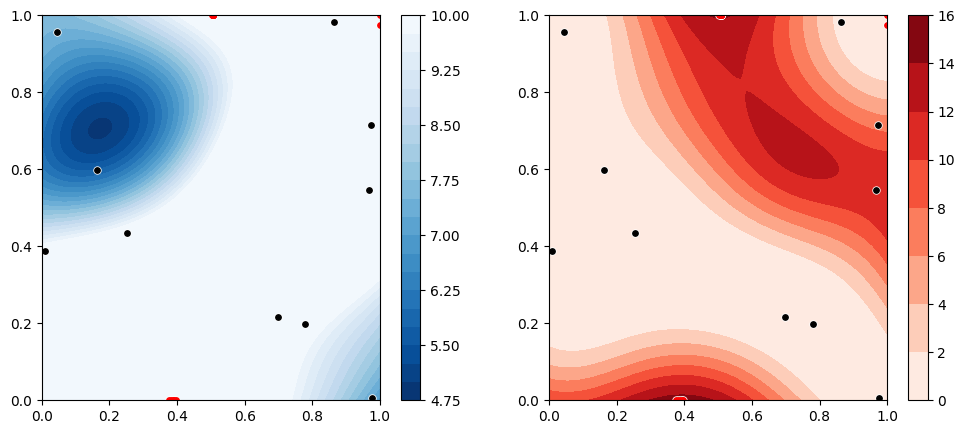

Eval at tensor([0.3719, 0.0000]) -> tensor([10.])
Best value 5.76 from 28 evaluations


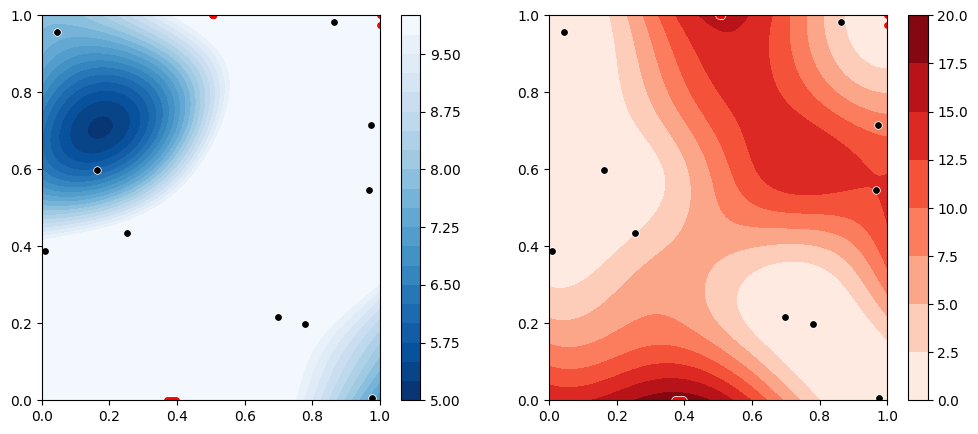

Eval at tensor([0.5075, 1.0000]) -> tensor([10.])
Best value 5.76 from 29 evaluations


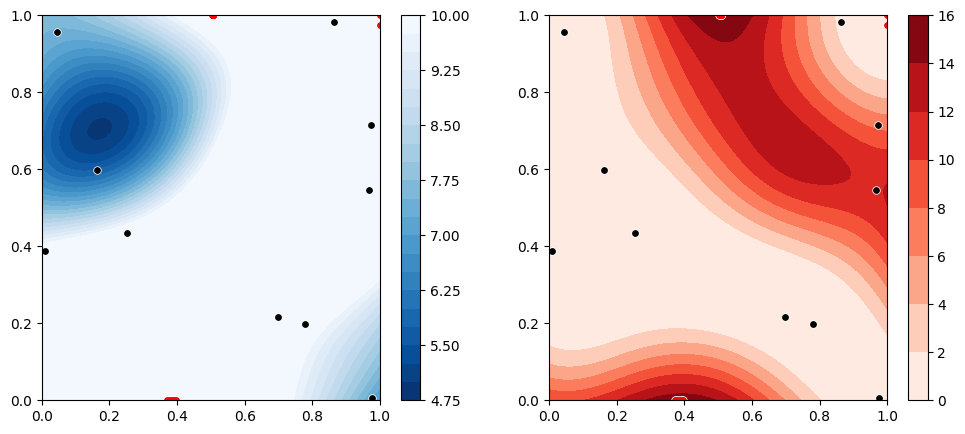

Eval at tensor([0.3920, 0.0000]) -> tensor([10.])
Best value 5.76 from 30 evaluations


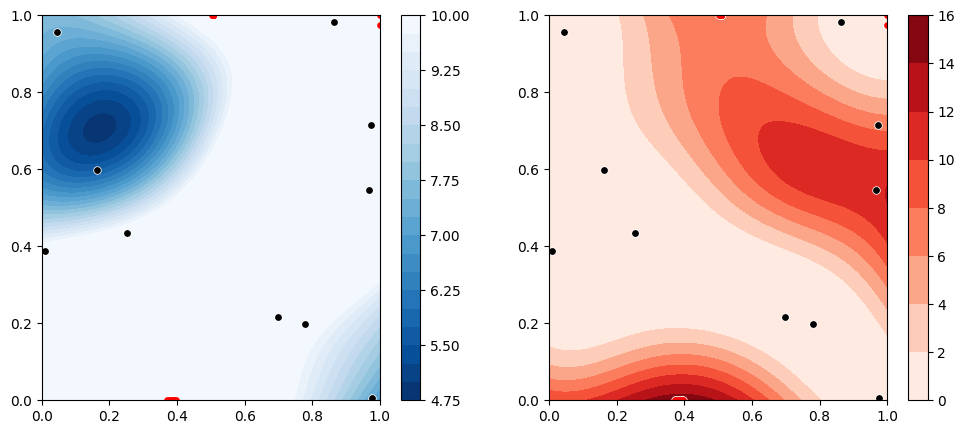

In [26]:
for i in range(20):
    X_tobit, y_tobit = bo_iteration_tobit(X_tobit, y_tobit)

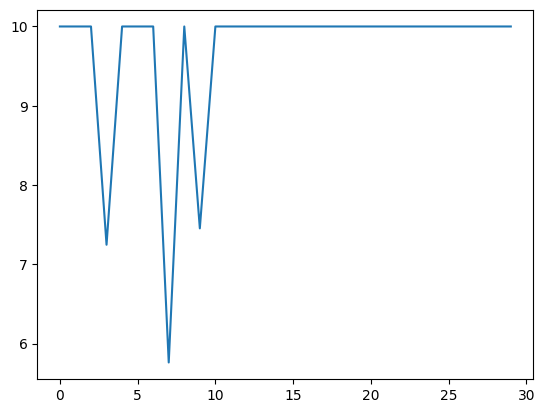

In [27]:
plt.plot(y_tobit);

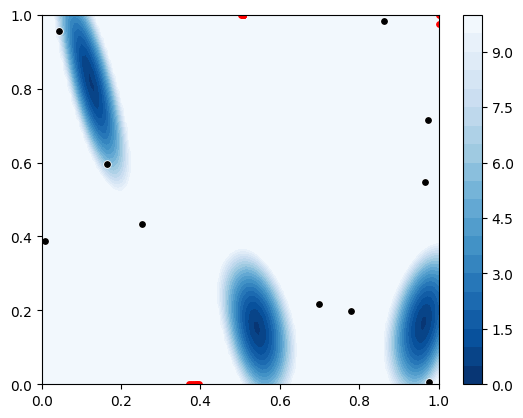

In [28]:
with torch.no_grad():
    plot_test_function(oracle)

plt.set_cmap(cmap='Blues_r')
plt.colorbar();
plt.scatter(X_tobit[:N_init,0], X_tobit[:N_init,1], s=100, marker='.', color='w', )
plt.scatter(X_tobit[:N_init,0], X_tobit[:N_init,1], s=60, marker='.', color='k', )
plt.scatter(X_tobit[N_init:,0], X_tobit[N_init:,1], s=100, marker='.', color='w', )
plt.scatter(X_tobit[N_init:,0], X_tobit[N_init:,1], s=60, marker='.', color='r', )